In [1]:
pip install -q -U tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import seaborn as sns
from IPython.display import display
import tensorflow_addons as tfa
from sklearn.metrics import classification_report
plt.rcParams['font.size'] = 12
plt.rcParams['lines.color'] ='#000000'
np.random.seed(42)

In [3]:
train_path = '../input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv'
test_path = '../input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv'

In [4]:
# import train and test data
train = pd.read_csv(train_path)
display(train.head())
test = pd.read_csv(test_path)
display(test.head())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [51]:
print('shape of training data:', train.shape) # (nrow, ncolumn)
print('shape of testing data:', test.shape)

''' na count over all rows and columns
first sum = sums over rows, last sum = sums over columns
'''
print('na count train:', train.isna().sum().sum())
print('na count test:', test.isna().sum().sum())

shape of training data: (27455, 785)
shape of testing data: (7172, 785)
na count train: 0
na count test: 0


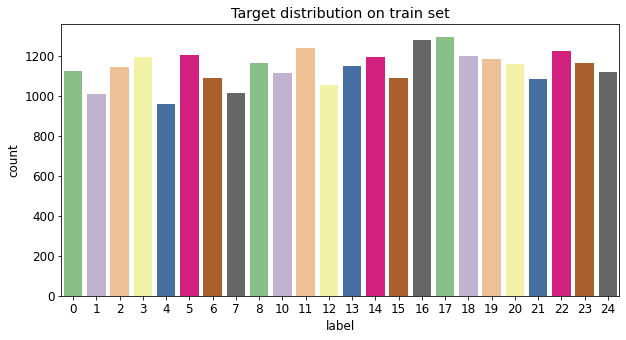

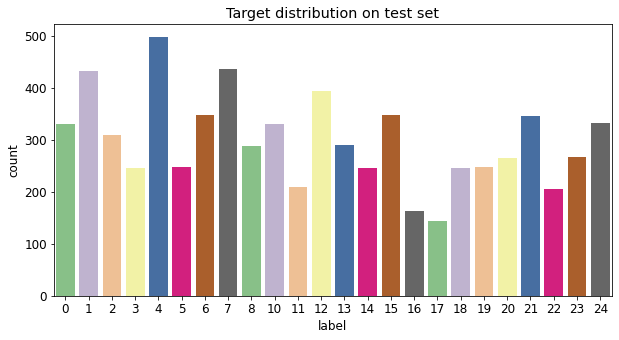

In [6]:
# plot label distribution
fig = plt.figure(figsize=(10,5))
ax = sns.countplot(x=train['label'], palette='Accent')
plt.title('Target distribution on train set')
plt.show()

fig = plt.figure(figsize=(10,5))
ax = sns.countplot(x=test['label'], palette='Accent')
plt.title('Target distribution on test set')
plt.show()

we could notice that there are no example in both train set and test set with label 9

In [7]:
X = train.drop('label', axis=1) # get feature columns
y = keras.utils.to_categorical(train['label']) # encode target

X_test = test.drop('label', axis=1)
y_test = keras.utils.to_categorical(test['label'])

In [8]:
# reshape square black and white images
def reshape_bw(X):
    samples, width, channel = X.shape[0], int(np.sqrt(X.shape[1])) , 1
    return X.values.reshape(samples, width, width, channel)

In [9]:
X = reshape_bw(X)
X_test = reshape_bw(X_test)
width, height, channel = X.shape[1], X.shape[2], X.shape[3]

label: 3


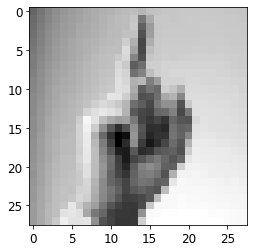

label: 6


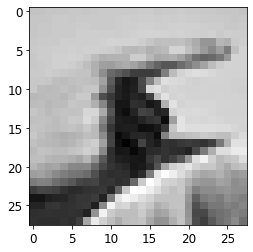

In [10]:
# plot a square black and white image
def plot_image(X, width):
    _ = plt.imshow(X.reshape(width, width), cmap='gray')
    plt.show()

# plot sample image
print('label:', y[0].argmax())    
plot_image(X[0], width)
print('label:', y_test[0].argmax())    
plot_image(X_test[0], width)

In [11]:
# split data into train and validation set with same target distribution as before spliting
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [12]:
# create data augmentor and fit it on train set
# feature = pixel
generator = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True, # make pixel intensity mean = 0
    featurewise_std_normalization=True, # make pixel intensity s.d. = 1
    height_shift_range=0.2, # shift image vertically (up or down) by 0.2 * 28 pixel
    width_shift_range=0.2, # shift image horizontally (left or right) by 0.2 * 28 pixel
    fill_mode='nearest'
)
generator.fit(X_train)

In [13]:
def plot_learning_curve(history):
    ephs = np.arange(0, len(history.history['loss'])) + 1
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(ephs, history.history['accuracy'], '--')
    plt.plot(ephs, history.history['val_accuracy'], '--')
    plt.legend(['accuracy', 'val_accuracy'])
    plt.subplot(1,2,2)
    plt.plot(ephs, history.history['loss'], '--')
    plt.plot(ephs, history.history['val_loss'], '--')
    plt.legend(['loss', 'val_loss'])
    plt.show()

In [14]:
def evaluate(model):
    loss_t, acc_t, pre_t, rec_t, f1_t = model.evaluate(generator.flow(X_train, y_train, batch_size=32))
    loss, acc, pre, rec, f1 = model.evaluate(generator.flow(X_test, y_test, batch_size=32))
    print()
    print(f"train loss: {loss_t}")
    print(f"train accuracy: {round(acc_t*100,2)} %")
    print(f"train precision: {pre_t}")
    print(f"train recall: {rec_t}")
    print(f"train f1: {f1_t}")
    print(f"test loss: {loss}")
    print(f"test accuracy: {round(acc*100,2)} %")
    print(f"test precision: {pre}")
    print(f"test recall: {rec}")
    print(f"test f1: {f1}")
    predictions = np.argmax(model.predict(X_test), axis=-1)
    classes = [str(i) for i in range(y_test.shape[1]) if i!= 9]
    print(classification_report(np.argmax(y_test, axis=-1), predictions, target_names=classes))

In [15]:
def get_callbacks(file_path):
    return [
          keras.callbacks.ReduceLROnPlateau(monitor='val_f1_score', mode='max', factor=0.3, patience=2, min_lr=0.00001),
          keras.callbacks.ModelCheckpoint(file_path, monitor='val_f1_score', mode='max', save_best_only=True),
          keras.callbacks.EarlyStopping(monitor='val_f1_score', mode='max', restore_best_weights=True, min_delta=1e-8, patience=3)
  ]

In [16]:
keras.backend.clear_session()
baseline_model = keras.models.Sequential()
baseline_model.add(keras.layers.Input(shape=X.shape[1:]))
baseline_model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
baseline_model.add(keras.layers.MaxPool2D((2, 2)))
baseline_model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
baseline_model.add(keras.layers.MaxPool2D((2, 2)))
baseline_model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
baseline_model.add(keras.layers.MaxPool2D((2, 2)))
baseline_model.add(keras.layers.Flatten())
baseline_model.add(keras.layers.Dense(y.shape[1], activation='softmax'))

# compile model
baseline_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        'accuracy', 
        keras.metrics.Precision(), 
        keras.metrics.Recall(), 
        tfa.metrics.F1Score(num_classes=y.shape[1], average='weighted')
    ]
)

2021-11-28 16:54:49.668940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 16:54:49.791405: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 16:54:49.792121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 16:54:49.793279: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [17]:
baseline_path = 'baseline.h5'
history_baseline = baseline_model.fit(
    generator.flow(X_train, y_train, batch_size=32),
    epochs=20,
    validation_data=generator.flow(X_val, y_val, batch_size=32),
    callbacks=get_callbacks(baseline_path),
    verbose=2
)

2021-11-28 16:54:52.211153: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2021-11-28 16:54:54.148500: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


687/687 - 17s - loss: 1.1546 - accuracy: 0.6480 - precision: 0.8646 - recall: 0.5194 - f1_score: 0.6477 - val_loss: 0.3144 - val_accuracy: 0.9031 - val_precision: 0.9377 - val_recall: 0.8694 - val_f1_score: 0.9026
Epoch 2/20
687/687 - 10s - loss: 0.2205 - accuracy: 0.9302 - precision: 0.9489 - recall: 0.9126 - f1_score: 0.9302 - val_loss: 0.1148 - val_accuracy: 0.9650 - val_precision: 0.9737 - val_recall: 0.9574 - val_f1_score: 0.9648
Epoch 3/20
687/687 - 9s - loss: 0.0972 - accuracy: 0.9702 - precision: 0.9756 - recall: 0.9647 - f1_score: 0.9702 - val_loss: 0.0960 - val_accuracy: 0.9701 - val_precision: 0.9736 - val_recall: 0.9658 - val_f1_score: 0.9702
Epoch 4/20
687/687 - 9s - loss: 0.0676 - accuracy: 0.9777 - precision: 0.9811 - recall: 0.9751 - f1_score: 0.9777 - val_loss: 0.0620 - val_accuracy: 0.9814 - val_precision: 0.9841 - val_recall: 0.9787 - val_f1_score: 0.9815
Epoch 5/20
687/687 - 10s - loss: 0.0486 - accuracy: 0.9846 - precision: 0.9866 - recall: 0.9830 - f1_score: 0.984

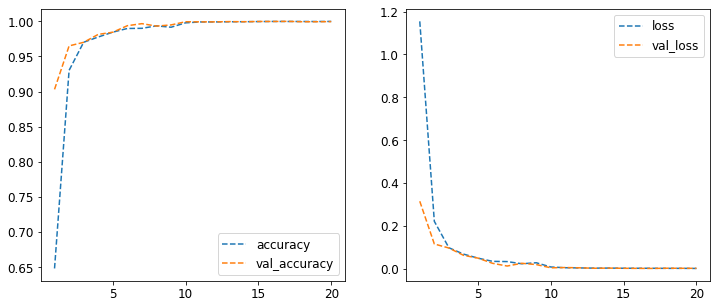

In [18]:
plot_learning_curve(history_baseline)

In [19]:
best_baseline = keras.models.load_model(baseline_path)
evaluate(best_baseline)

225/225 [==============================] - 3s 11ms/step - loss: 0.0222 - accuracy: 0.9929 - precision: 0.9937 - recall: 0.9927 - f1_score: 0.9929

train loss: 0.0009519460145384073
train accuracy: 99.98 %
train precision: 0.9998179078102112
train recall: 0.9998179078102112
train f1: 0.9998178482055664
test loss: 0.022214865311980247
test accuracy: 99.29 %
test precision: 0.9937194585800171
test recall: 0.9927495718002319
test f1: 0.9928872585296631
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       331
           1       0.96      1.00      0.98       432
           2       1.00      0.89      0.94       310
           3       1.00      0.68      0.81       245
           4       1.00      0.91      0.95       498
           5       1.00      0.96      0.98       247
           6       1.00      0.95      0.97       348
           7       0.99      0.95      0.97       436
           8       1.00      0.86      0.93       288
      

In [24]:
keras.backend.clear_session()
drop_model = keras.models.Sequential()
drop_model.add(keras.layers.Input(shape=X.shape[1:]))
drop_model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
drop_model.add(keras.layers.MaxPool2D((2, 2)))
drop_model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
drop_model.add(keras.layers.Dropout(0.1))
drop_model.add(keras.layers.MaxPool2D((2, 2)))
drop_model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
drop_model.add(keras.layers.Dropout(0.2))
drop_model.add(keras.layers.MaxPool2D((2, 2)))
drop_model.add(keras.layers.Flatten())
drop_model.add(keras.layers.Dense(128, activation='relu'))
drop_model.add(keras.layers.Dropout(0.2))
drop_model.add(keras.layers.Dense(y.shape[1], activation='softmax'))

# compile model
drop_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        'accuracy', 
        keras.metrics.Precision(), 
        keras.metrics.Recall(), 
        tfa.metrics.F1Score(num_classes=y.shape[1], average='weighted')
    ]
)

In [25]:
dropout_path = 'dropout.h5'
history_dropout = drop_model.fit(
    generator.flow(X_train, y_train, batch_size=32),
    epochs=20,
    validation_data=generator.flow(X_val, y_val, batch_size=32),
    callbacks=get_callbacks(dropout_path),
    verbose=2
)

Epoch 1/20
687/687 - 11s - loss: 1.4660 - accuracy: 0.5418 - precision: 0.8141 - recall: 0.3993 - f1_score: 0.5398 - val_loss: 0.4263 - val_accuracy: 0.8884 - val_precision: 0.9441 - val_recall: 0.7964 - val_f1_score: 0.8880
Epoch 2/20
687/687 - 9s - loss: 0.3627 - accuracy: 0.8786 - precision: 0.9121 - recall: 0.8447 - f1_score: 0.8785 - val_loss: 0.1557 - val_accuracy: 0.9572 - val_precision: 0.9718 - val_recall: 0.9401 - val_f1_score: 0.9573
Epoch 3/20
687/687 - 9s - loss: 0.1854 - accuracy: 0.9376 - precision: 0.9500 - recall: 0.9256 - f1_score: 0.9376 - val_loss: 0.0830 - val_accuracy: 0.9811 - val_precision: 0.9863 - val_recall: 0.9703 - val_f1_score: 0.9811
Epoch 4/20
687/687 - 10s - loss: 0.1254 - accuracy: 0.9582 - precision: 0.9647 - recall: 0.9519 - f1_score: 0.9582 - val_loss: 0.0364 - val_accuracy: 0.9931 - val_precision: 0.9945 - val_recall: 0.9902 - val_f1_score: 0.9931
Epoch 5/20
687/687 - 10s - loss: 0.0824 - accuracy: 0.9720 - precision: 0.9759 - recall: 0.9690 - f1_s

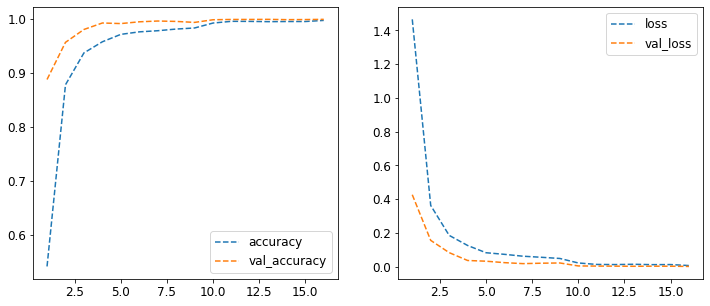

In [26]:
plot_learning_curve(history_dropout)

In [27]:
best_dropout = keras.models.load_model(dropout_path)
evaluate(best_dropout)

225/225 [==============================] - 3s 12ms/step - loss: 0.0188 - accuracy: 0.9943 - precision: 0.9955 - recall: 0.9932 - f1_score: 0.9943

train loss: 0.0022264481522142887
train accuracy: 99.96 %
train precision: 0.9996357560157776
train recall: 0.9995902180671692
train f1: 0.999590277671814
test loss: 0.018769241869449615
test accuracy: 99.43 %
test precision: 0.9955276250839233
test recall: 0.9931678771972656
test f1: 0.994274914264679
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       331
           1       0.98      0.98      0.98       432
           2       0.88      1.00      0.93       310
           3       1.00      0.90      0.94       245
           4       0.99      0.94      0.97       498
           5       1.00      0.95      0.97       247
           6       1.00      0.68      0.81       348
           7       0.87      1.00      0.93       436
           8       0.95      1.00      0.97       288
        

In [28]:
keras.backend.clear_session()
drop_model2 = keras.models.Sequential()
drop_model2.add(keras.layers.Input(shape=X.shape[1:]))
drop_model2.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
drop_model2.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
drop_model2.add(keras.layers.Dropout(0.1))
drop_model2.add(keras.layers.MaxPool2D((2, 2)))
drop_model2.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
drop_model2.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
drop_model2.add(keras.layers.Dropout(0.2))
drop_model2.add(keras.layers.MaxPool2D((2, 2)))
drop_model2.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
drop_model2.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
drop_model2.add(keras.layers.Dropout(0.3))
drop_model2.add(keras.layers.MaxPool2D((2, 2)))
drop_model2.add(keras.layers.Flatten())
drop_model2.add(keras.layers.Dense(128, activation='relu'))
drop_model2.add(keras.layers.Dropout(0.2))
drop_model2.add(keras.layers.Dense(y.shape[1], activation='softmax'))

# compile model
drop_model2.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        'accuracy', 
        keras.metrics.Precision(), 
        keras.metrics.Recall(), 
        tfa.metrics.F1Score(num_classes=y.shape[1], average='weighted')
    ]
)

In [29]:
dropout_path2 = 'dropout2.h5'
history_dropout2 = drop_model2.fit(
    generator.flow(X_train, y_train, batch_size=32),
    epochs=20,
    validation_data=generator.flow(X_val, y_val, batch_size=32),
    callbacks=get_callbacks(dropout_path2),
    verbose=2
)

Epoch 1/20
687/687 - 12s - loss: 1.3805 - accuracy: 0.5619 - precision: 0.8239 - recall: 0.4509 - f1_score: 0.5629 - val_loss: 0.3360 - val_accuracy: 0.9058 - val_precision: 0.9530 - val_recall: 0.8410 - val_f1_score: 0.9048
Epoch 2/20
687/687 - 10s - loss: 0.2026 - accuracy: 0.9319 - precision: 0.9445 - recall: 0.9199 - f1_score: 0.9319 - val_loss: 0.1360 - val_accuracy: 0.9665 - val_precision: 0.9748 - val_recall: 0.9506 - val_f1_score: 0.9666
Epoch 3/20
687/687 - 10s - loss: 0.0938 - accuracy: 0.9699 - precision: 0.9742 - recall: 0.9667 - f1_score: 0.9699 - val_loss: 0.0286 - val_accuracy: 0.9931 - val_precision: 0.9940 - val_recall: 0.9914 - val_f1_score: 0.9931
Epoch 4/20
687/687 - 11s - loss: 0.0579 - accuracy: 0.9824 - precision: 0.9845 - recall: 0.9805 - f1_score: 0.9824 - val_loss: 0.0185 - val_accuracy: 0.9956 - val_precision: 0.9964 - val_recall: 0.9953 - val_f1_score: 0.9956
Epoch 5/20
687/687 - 10s - loss: 0.0503 - accuracy: 0.9854 - precision: 0.9868 - recall: 0.9840 - f1

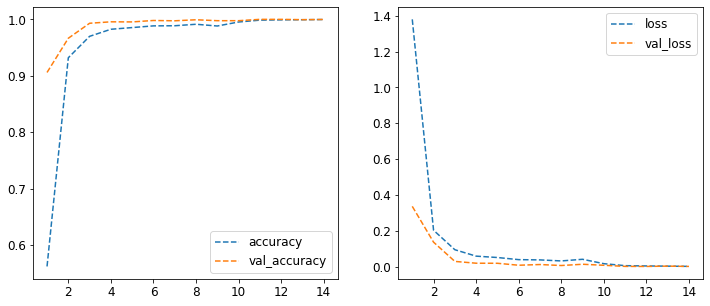

In [30]:
plot_learning_curve(history_dropout2)

In [31]:
best_dropout2 = keras.models.load_model(dropout_path2)
evaluate(best_dropout2)

225/225 [==============================] - 3s 12ms/step - loss: 0.0071 - accuracy: 0.9972 - precision: 0.9975 - recall: 0.9967 - f1_score: 0.9972

train loss: 0.0012784376740455627
train accuracy: 99.97 %
train precision: 0.9997268319129944
train recall: 0.999681293964386
train f1: 0.999681293964386
test loss: 0.007122088689357042
test accuracy: 99.72 %
test precision: 0.9974881410598755
test recall: 0.99665367603302
test f1: 0.9972144365310669
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      0.99      0.99       432
           2       0.99      1.00      1.00       310
           3       0.97      1.00      0.98       245
           4       1.00      0.99      1.00       498
           5       1.00      1.00      1.00       247
           6       0.95      0.99      0.97       348
           7       0.99      1.00      0.99       436
           8       1.00      1.00      1.00       288
          

In [44]:
keras.backend.clear_session()
drop_model3 = keras.models.Sequential()
drop_model3.add(keras.layers.Input(shape=X.shape[1:]))
drop_model3.add(keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'))
drop_model3.add(keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'))
drop_model3.add(keras.layers.Dropout(0.1))
drop_model3.add(keras.layers.MaxPool2D((2, 2)))
drop_model3.add(keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
drop_model3.add(keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
drop_model3.add(keras.layers.Dropout(0.2))
drop_model3.add(keras.layers.MaxPool2D((2, 2)))
drop_model3.add(keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'))
drop_model3.add(keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'))
drop_model3.add(keras.layers.Dropout(0.3))
drop_model3.add(keras.layers.MaxPool2D((2, 2)))
drop_model3.add(keras.layers.Flatten())
drop_model3.add(keras.layers.Dense(128, activation='relu'))
drop_model3.add(keras.layers.Dropout(0.2))
drop_model3.add(keras.layers.Dense(y.shape[1], activation='softmax'))

# compile model
drop_model3.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        'accuracy', 
        keras.metrics.Precision(), 
        keras.metrics.Recall(), 
        tfa.metrics.F1Score(num_classes=y.shape[1], average='weighted')
    ]
)

In [45]:
dropout_path3 = 'dropout3.h5'
history_dropout3 = drop_model3.fit(
    generator.flow(X_train, y_train, batch_size=32),
    epochs=20,
    validation_data=generator.flow(X_val, y_val, batch_size=32),
    callbacks=get_callbacks(dropout_path3),
    verbose=2
)

Epoch 1/20
687/687 - 12s - loss: 1.4299 - accuracy: 0.5487 - precision: 0.8396 - recall: 0.4501 - f1_score: 0.5515 - val_loss: 0.2999 - val_accuracy: 0.9157 - val_precision: 0.9445 - val_recall: 0.8652 - val_f1_score: 0.9155
Epoch 2/20
687/687 - 10s - loss: 0.1483 - accuracy: 0.9567 - precision: 0.9639 - recall: 0.9479 - f1_score: 0.9567 - val_loss: 0.0785 - val_accuracy: 0.9831 - val_precision: 0.9873 - val_recall: 0.9734 - val_f1_score: 0.9831
Epoch 3/20
687/687 - 10s - loss: 0.0693 - accuracy: 0.9811 - precision: 0.9840 - recall: 0.9775 - f1_score: 0.9811 - val_loss: 0.0491 - val_accuracy: 0.9876 - val_precision: 0.9890 - val_recall: 0.9842 - val_f1_score: 0.9877
Epoch 4/20
687/687 - 11s - loss: 0.0611 - accuracy: 0.9849 - precision: 0.9873 - recall: 0.9821 - f1_score: 0.9849 - val_loss: 0.0464 - val_accuracy: 0.9898 - val_precision: 0.9937 - val_recall: 0.9805 - val_f1_score: 0.9898
Epoch 5/20
687/687 - 10s - loss: 0.0279 - accuracy: 0.9938 - precision: 0.9946 - recall: 0.9925 - f1

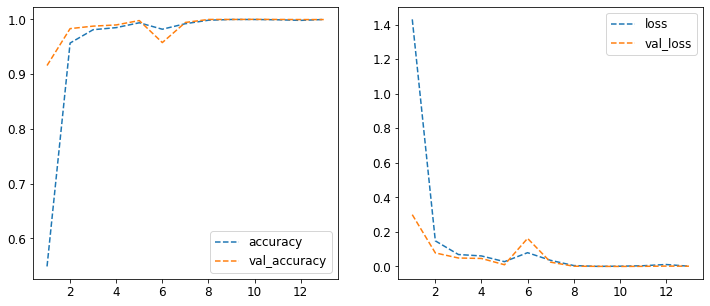

In [46]:
plot_learning_curve(history_dropout3)

In [47]:
best_dropout3 = keras.models.load_model(dropout_path3)
evaluate(best_dropout3)

225/225 [==============================] - 3s 12ms/step - loss: 0.0083 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9982 - f1_score: 0.9983

train loss: 0.00036143968463875353
train accuracy: 100.0 %
train precision: 0.9999544620513916
train recall: 0.9999089241027832
train f1: 0.9999544620513916
test loss: 0.00834156759083271
test accuracy: 99.83 %
test precision: 0.9983265995979309
test recall: 0.9981874227523804
test f1: 0.9983258247375488
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       0.98      1.00      0.99       432
           2       1.00      1.00      1.00       310
           3       1.00      1.00      1.00       245
           4       1.00      1.00      1.00       498
           5       1.00      0.98      0.99       247
           6       1.00      0.99      1.00       348
           7       1.00      1.00      1.00       436
           8       1.00      0.98      0.99       288
      

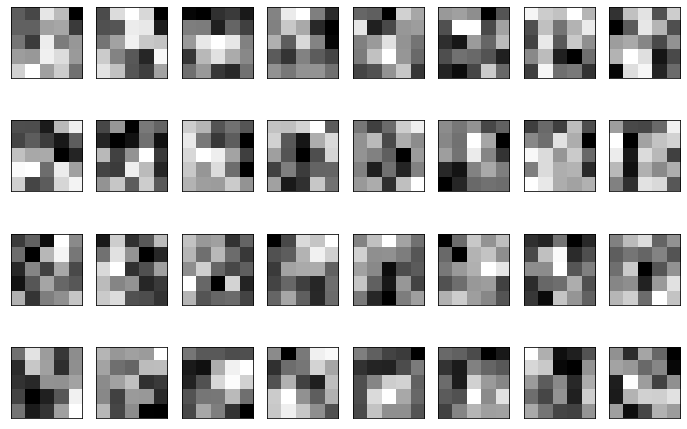

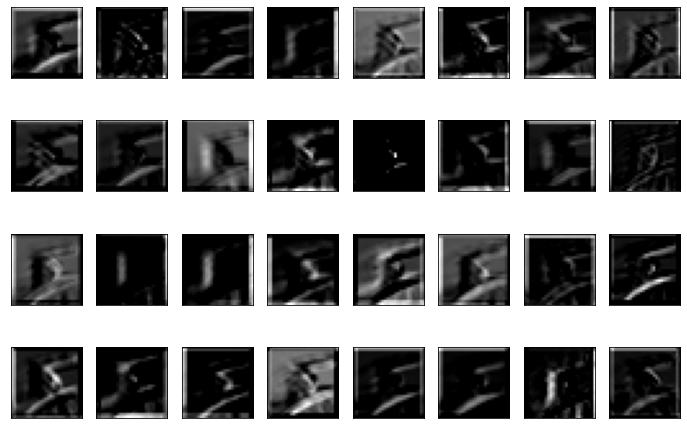

In [61]:
# cr. https://github.com/bnsreenu/python_for_microscopists/blob/master/152-visualizing_conv_layer_outputs.py
layer = best_dropout3.layers
idx = 0
filters, biases = best_dropout3.layers[idx].get_weights()  

main_fig = plt.figure(figsize=(12, 8))
columns = 8
rows = 4
n_filters = columns * rows
for i in range(1, n_filters +1):
    f = filters[:, :, :, i-1]
    fig = plt.subplot(rows, columns, i)
    fig.set_xticks([]) 
    fig.set_yticks([])
    plt.imshow(f[:, :, 0], cmap='gray')
plt.show()    

conv_layer_index = [0, 1, 4, 5, 8, 9]
conv_layer_index = [0]
outputs = [best_dropout3.layers[i].output for i in conv_layer_index]
model_short = keras.models.Model(inputs=best_dropout3.inputs, outputs=[outputs])

feature_output = model_short.predict(X_test[0:1])


columns = 8
rows = 4
for ftr in feature_output:
    fig=plt.figure(figsize=(12, 8))
    for i in range(1, columns*rows +1):
        fig =plt.subplot(rows, columns, i)
        fig.set_xticks([])
        fig.set_yticks([])
        plt.imshow(ftr[0, :, :, i-1], cmap='gray')
    plt.show()